# Sentiment Analysis
Here we will be answering the following questions
1. What are the cafe rankings based on sentiment?
2. Are sentiment and rating related?
3. Is there a difference in cafe rankings when sorting by COMPOUND_MEAN instead of  AVERAGE_RATINGS?

But before that, we have to import some modules and also the dataframe that we collected and pre-processed.

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import seaborn as sns
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
reviews_df = pd.read_excel("../2. Data Pre-processing/kl_selangor_cafe_reviews.xlsx")
reviews_df.head(5)

,rating,cafe_name,number_of_images,estimated_date,description_processed
0,4,6Yi Cafe,10,2024-01-08,nice quite friendly cafe food like homely meal...
1,4,6Yi Cafe,10,2023-12-08,nice quiet place coffee cake lunch design retr...
2,5,6Yi Cafe,2,2023-12-08,rare simple cosy cafe open till 12am considere...
3,5,6Yi Cafe,19,2023-06-08,kindhearted cafe owner lot street abandoned an...
4,4,6Yi Cafe,2,2023-09-08,cosy environment lot quality books free read o...


Then we have to get the Sentiment Analyser Ready

* We are going to use the pre-trained sentiment classifier that comes with NLTK. It's it trained on tweets. It return 4 values: positive, negative, neutral, and compound. Compound will be of special interest to us. It is the normalized sum of positive and negative. 


In [7]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
#run this cell to see how the sentiment analyzer works on positive sentiments
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I loved the pasta so much! Will definitely come again.")

{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'compound': 0.7995}

In [9]:
#run this cell to see how the sentiment analyzer works on negative sentiments
sia.polarity_scores("The food was terrible! How can they serve us such a thing?")

{'neg': 0.253, 'neu': 0.747, 'pos': 0.0, 'compound': -0.5255}

Now that the sentiment analyser is ready, we can start answering our three questions

## 1. What are the cafe rankings based on sentiment?
To answer this question, we need to
<br><br>a. Get the sentiment score for each review.
<br><br>b. Group the reviews by cafe
<br><br>c. Sort the cafe based on the mean sentiment score (compound)
<br><br>d. Visualise the ranking of cafe based on compound

### a. Get the sentiment score for each review

In [10]:
#create a new column called polarity and apply the sia method to the description_processed column with a lambda expression
reviews_df['polarity'] = reviews_df['description_processed'].apply(lambda x: sia.polarity_scores(x))
reviews_df.head(5)

,rating,cafe_name,number_of_images,estimated_date,description_processed,polarity
0,4,6Yi Cafe,10,2024-01-08,nice quite friendly cafe food like homely meal...,"{'neg': 0.0, 'neu': 0.554, 'pos': 0.446, 'comp..."
1,4,6Yi Cafe,10,2023-12-08,nice quiet place coffee cake lunch design retr...,"{'neg': 0.046, 'neu': 0.661, 'pos': 0.293, 'co..."
2,5,6Yi Cafe,2,2023-12-08,rare simple cosy cafe open till 12am considere...,"{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'comp..."
3,5,6Yi Cafe,19,2023-06-08,kindhearted cafe owner lot street abandoned an...,"{'neg': 0.072, 'neu': 0.577, 'pos': 0.351, 'co..."
4,4,6Yi Cafe,2,2023-09-08,cosy environment lot quality books free read o...,"{'neg': 0.0, 'neu': 0.498, 'pos': 0.502, 'comp..."


In [11]:
#run this cell to transform the polarity dictionary into columns of the DataFrame
reviews_df[['neg', 'neu', 'pos', 'compound']] = reviews_df['polarity'].apply(pd.Series)

#then drop the old polarity column
reviews_df = reviews_df.drop('polarity', axis=1)

reviews_df.head(5)

,rating,cafe_name,number_of_images,estimated_date,description_processed,neg,neu,pos,compound
0,4,6Yi Cafe,10,2024-01-08,nice quite friendly cafe food like homely meal...,0.000,0.554,0.446,0.9538
1,4,6Yi Cafe,10,2023-12-08,nice quiet place coffee cake lunch design retr...,0.046,0.661,0.293,0.9257
2,5,6Yi Cafe,2,2023-12-08,rare simple cosy cafe open till 12am considere...,0.000,0.764,0.236,0.7964
3,5,6Yi Cafe,19,2023-06-08,kindhearted cafe owner lot street abandoned an...,0.072,0.577,0.351,0.8910
4,4,6Yi Cafe,2,2023-09-08,cosy environment lot quality books free read o...,0.000,0.498,0.502,0.9337


### b. Group the reviews by cafe

In [12]:
# Group by 'cafe_name' and perform the required aggregations
grouped_df = reviews_df.groupby('cafe_name').agg({
    # Get the number of ratings,
    'compound': 'mean',
    'rating': 'mean',
}).reset_index()
grouped_df

# Set column names
grouped_df.columns = ['cafe_name', 'compound_mean','average_rating']

grouped_df.head(5)

,cafe_name,compound_mean,average_rating
0,6Yi Cafe,0.805050,4.375
1,ALLO by The Owls Cafe,0.742400,3.875
2,AMP Cafe,0.859888,4.500
3,ANT Cafe & Bar,0.854725,4.125
4,AOOO Melbourne Cafe,0.924388,4.875


### c. Sort the cafe based on the mean sentiment score (compound)

In [13]:
sort_by_compound = grouped_df.sort_values(by='compound_mean', ascending=False).reset_index(drop=True)
sort_by_compound = sort_by_compound.drop('average_rating', axis=1)
sort_by_compound["compound_ranking"] =  range(1,86)
sort_by_compound.head(5)

,cafe_name,compound_mean,compound_ranking
0,Lisette's Café & Bakery @ Bangsar,0.954775,1
1,Emilyns & Cafe,0.943987,2
2,半刻 Ban Ke Cafe @ Happy Mansion,0.939425,3
3,Milko Cafe',0.939312,4
4,LOKL Coffee Co,0.937275,5


### d. Visualise the ranking of cafe based on compound

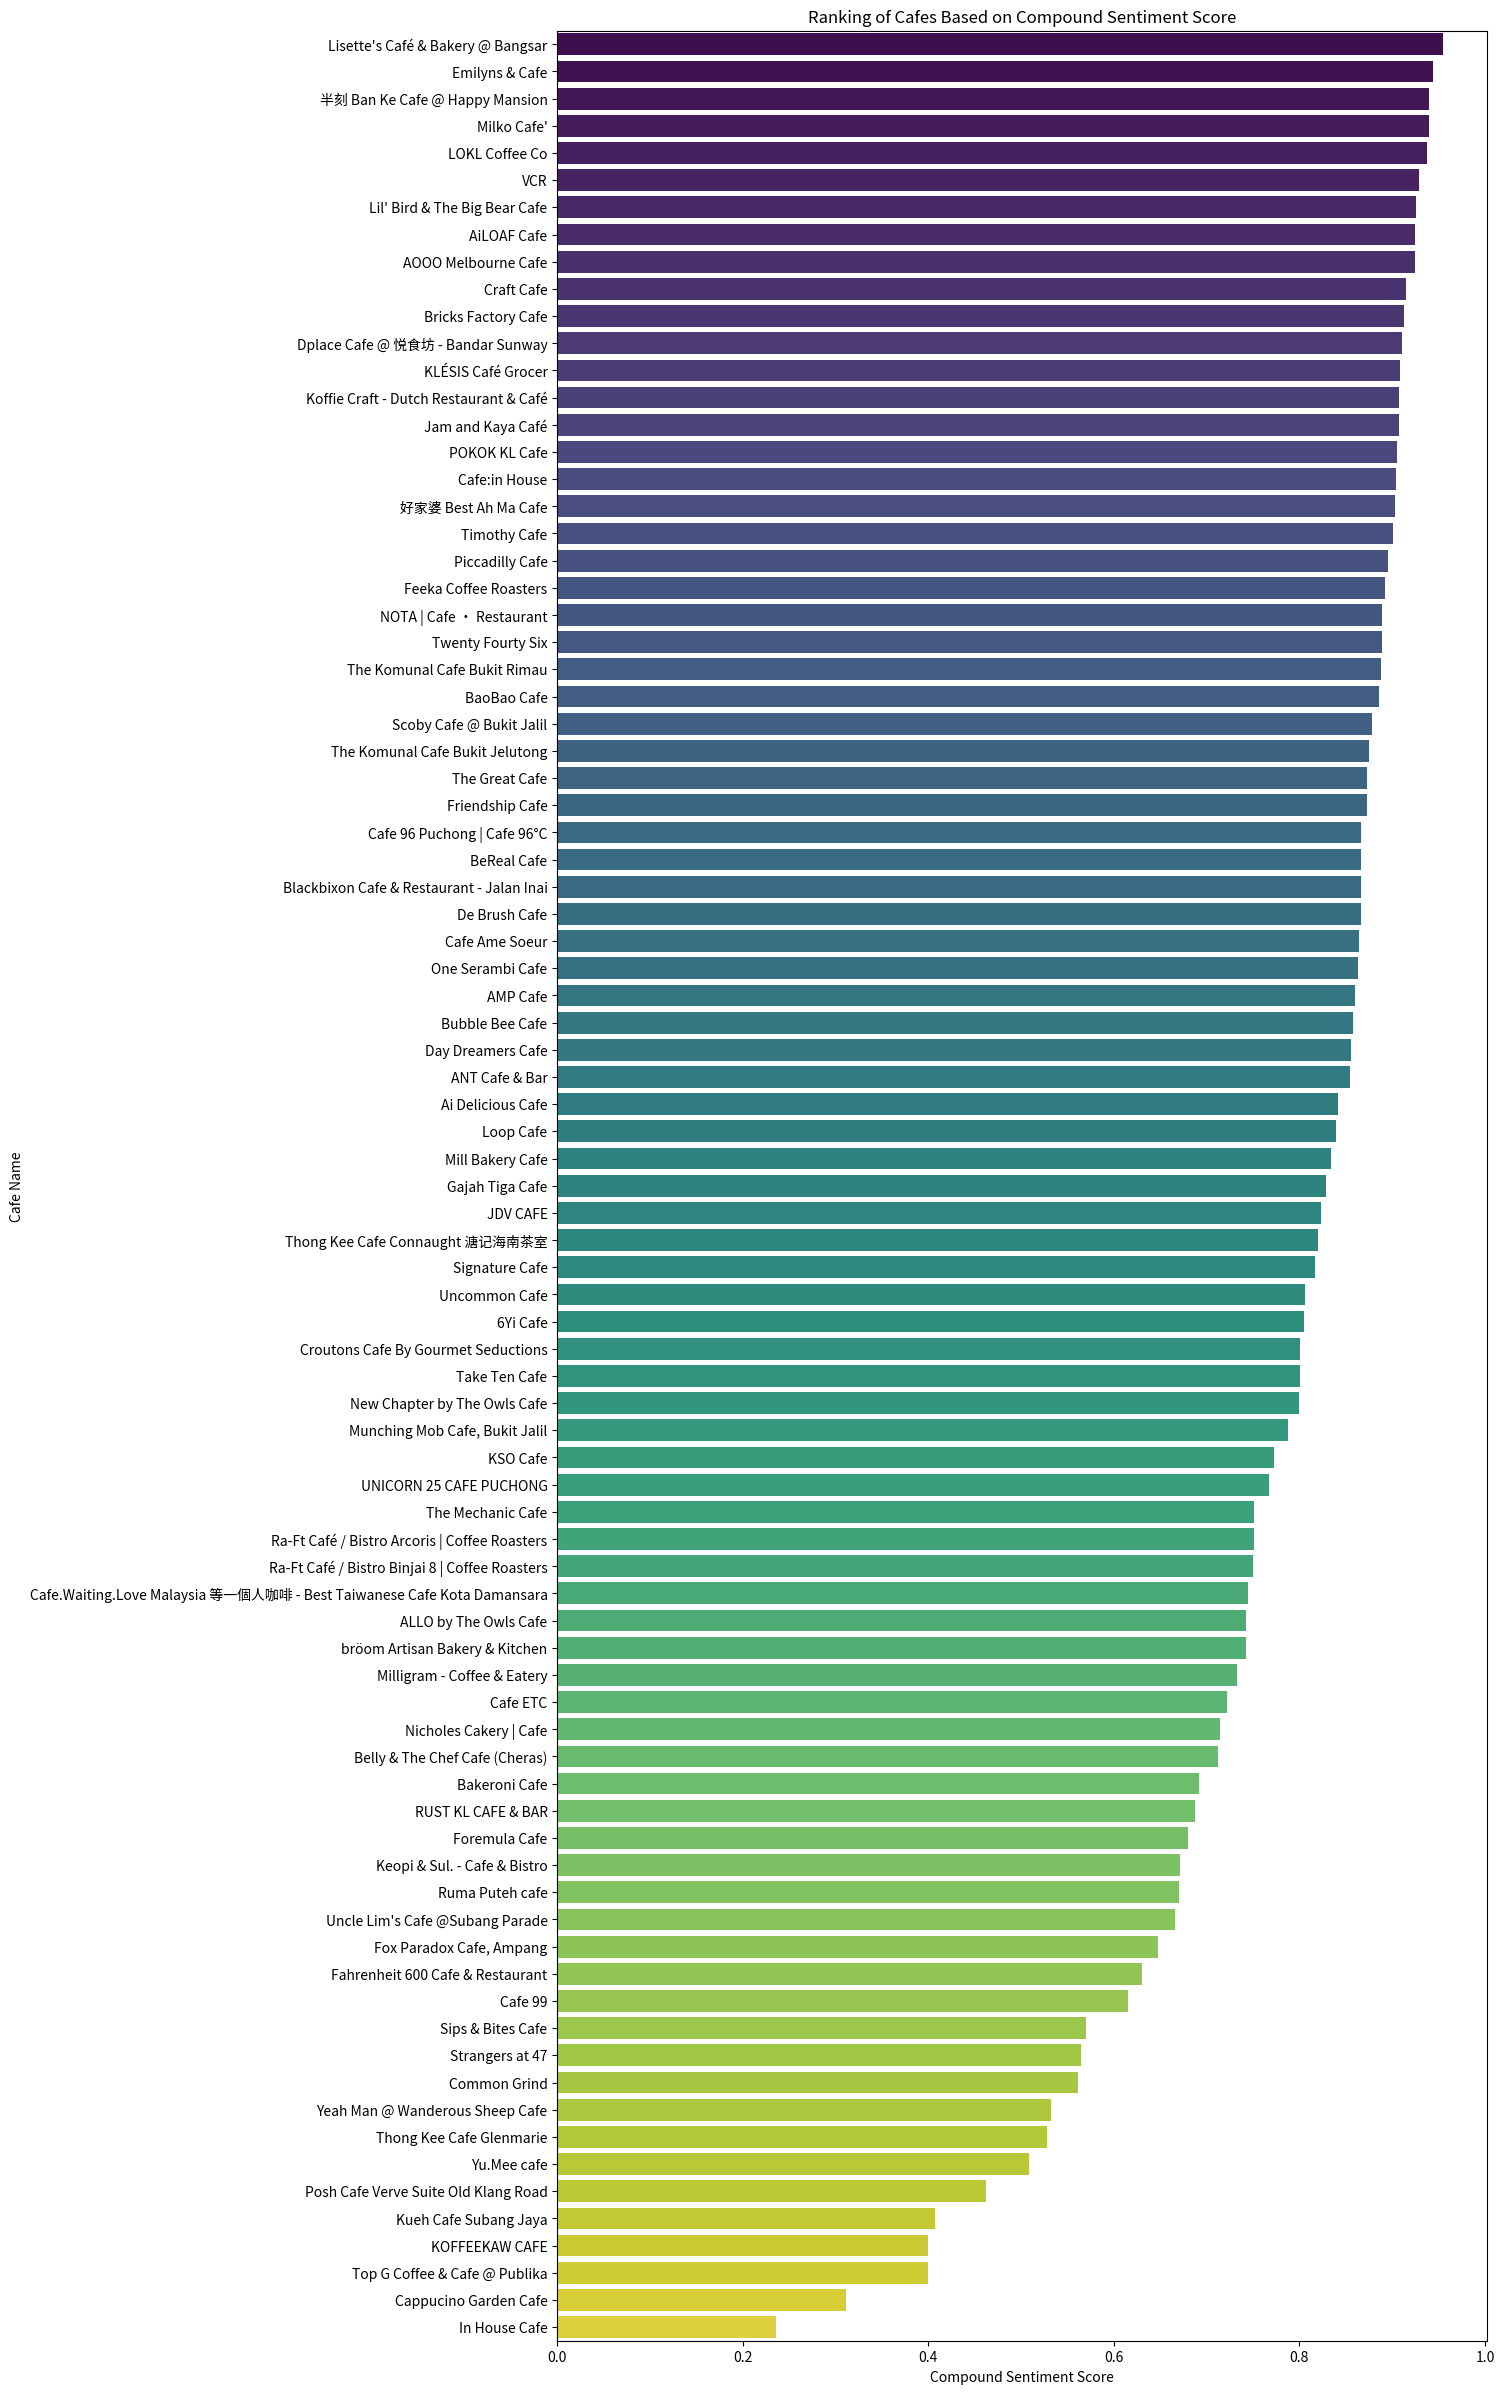

In [9]:
# Set the font family to one that supports a wide range of characters such as Chinese Characters
plt.rcParams['font.family'] = 'Noto Sans SC'
# Set the size of the plot
plt.figure(figsize=(12, 30))

sns.barplot(x='compound_mean', y='cafe_name', hue="cafe_name", data=sort_by_compound, palette='viridis', dodge=False, legend=False)
plt.title('Ranking of Cafes Based on Compound Sentiment Score')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Cafe Name')

# Show the plots
plt.show()

Section Conclusion 1: The cafe ranking (by sentiment) can be seen in the above visual.

In [14]:
# Top 10 cafes by compound score
sort_by_compound.head(10)

,cafe_name,compound_mean,compound_ranking
0,Lisette's Café & Bakery @ Bangsar,0.954775,1
1,Emilyns & Cafe,0.943987,2
2,半刻 Ban Ke Cafe @ Happy Mansion,0.939425,3
3,Milko Cafe',0.939312,4
4,LOKL Coffee Co,0.937275,5
5,VCR,0.928925,6
6,Lil' Bird & The Big Bear Cafe,0.925162,7
7,AiLOAF Cafe,0.924813,8
8,AOOO Melbourne Cafe,0.924388,9
9,Craft Cafe,0.915438,10


Section Conclusion 2: The top 10 cafes (by sentiment) can be seen above

In [ ]:
# Bottom 10 cafes by compound score
sort_by_compound.tail(10)

,cafe_name,compound_mean,compound_ranking
75,Common Grind,0.561538,76
76,Yeah Man @ Wanderous Sheep Cafe,0.532075,77
77,Thong Kee Cafe Glenmarie,0.528012,78
78,Yu.Mee cafe,0.508088,79
79,Posh Cafe Verve Suite Old Klang Road,0.461913,80
80,Kueh Cafe Subang Jaya,0.407600,81
81,KOFFEEKAW CAFE,0.399625,82
82,Top G Coffee & Cafe @ Publika,0.399125,83
83,Cappucino Garden Cafe,0.311337,84
84,In House Cafe,0.235563,85


Section Conclusion 3: The bottmom 10 cafes (by sentiment) can be seen above

## 2. Are sentiment and rating related?
To answer this question, we need to visualise the relationship of rating with compound score

For reviews with 5 star ratings:
sum compound:  282.998
mean compound:  0.87615479876161

For reviews with 4 star ratings:
sum compound:  185.1157
mean compound:  0.826409375

For reviews with 3 star ratings:
sum compound:  48.7536
mean compound:  0.6331636363636364

For reviews with 2 star ratings:
sum compound:  8.6203
mean compound:  0.33155

For reviews with 1 star ratings:
sum compound:  1.6775
mean compound:  0.05591666666666667



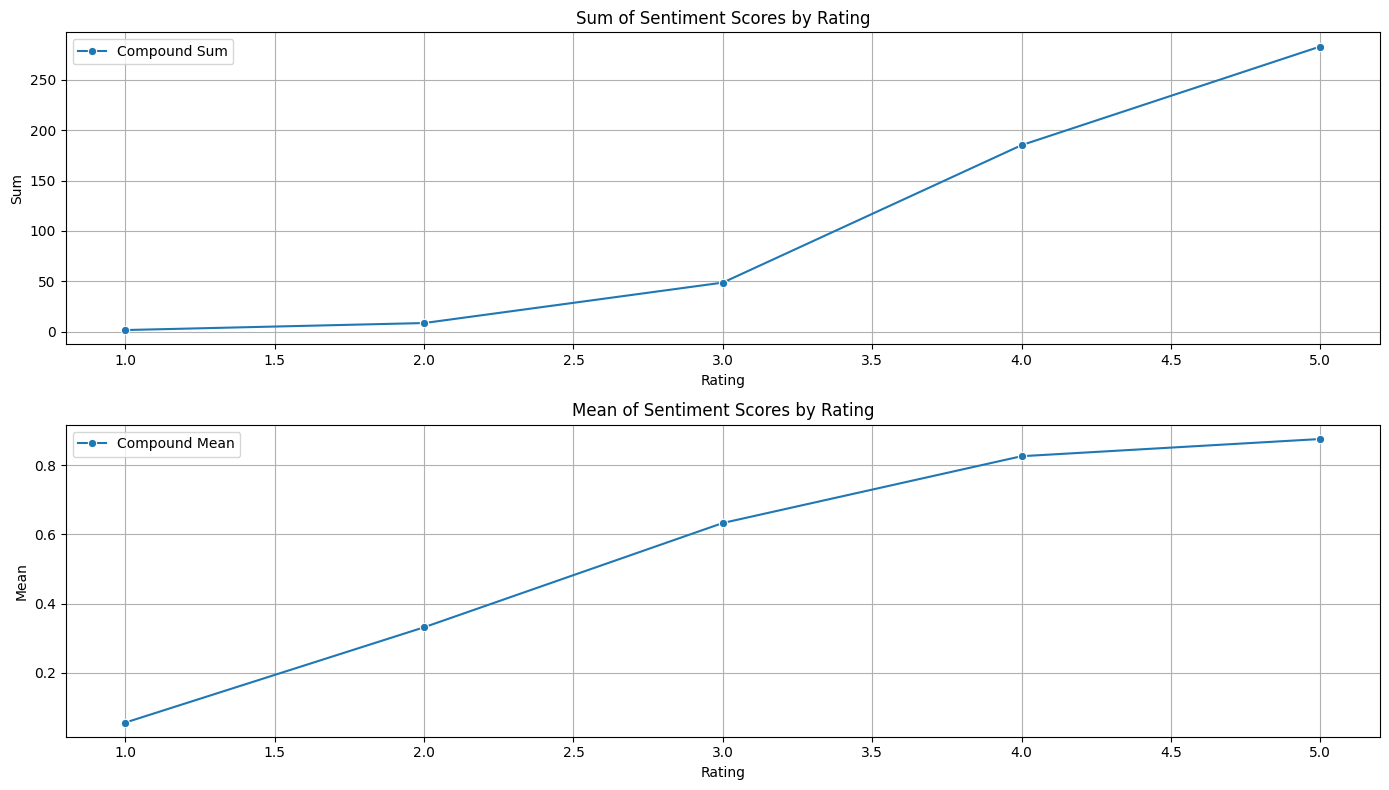

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean


# Initialize lists to store the results
ratings = []
compound_sums = []
compound_means = []

# Compute sums and means for each rating group
for i in range(5, 0, -1):
    review_group = reviews_df[reviews_df['rating'] == i].reset_index(drop=True)
    pos_sum = sum(review_group['pos'])
    neg_sum = sum(review_group['neg'])
    compound_sum = sum(review_group['compound'])
    pos_mean = mean(review_group['pos'])
    neg_mean = mean(review_group['neg'])
    compound_mean = mean(review_group['compound'])
    
    ratings.append(i)
    compound_sums.append(compound_sum)
    compound_means.append(compound_mean)
    print(f"For reviews with {i} star ratings:")
    print("sum compound: ", compound_sum)
    print("mean compound: ", compound_mean)
    print("")

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Rating': ratings,
    'Compound Sum': compound_sums,
    'Compound Mean': compound_means
})

# Plot the results
plt.figure(figsize=(14, 8))

# Plot sums
plt.subplot(2, 1, 1)
sns.lineplot(data=plot_data, x='Rating', y='Compound Sum', label='Compound Sum', marker='o')
plt.title('Sum of Sentiment Scores by Rating')
plt.xlabel('Rating')
plt.ylabel('Sum')
plt.legend()
plt.grid(True)

# Plot means
plt.subplot(2, 1, 2)
sns.lineplot(data=plot_data, x='Rating', y='Compound Mean', label='Compound Mean', marker='o')
plt.title('Mean of Sentiment Scores by Rating')
plt.xlabel('Rating')
plt.ylabel('Mean')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Section Conclusion: As you can see, the compound score increases with rating. This means that the higher the rating, the better the sentiment of the review. Therefore, sentiment and rating are positively correlated.

Note: The lines in "SUM of compound graph" have different gradients than the lines in the "MEAN of compound graph".
<br>This is because the number of reviews for each rating is different.
* Number of 5-star reviews: 323
* Number of 4-star reviews: 224
* Number of 3-star reviews: 77
* Number of 2-star reviews: 26
* Number of 1-star reviews: 30

## 3. Is there a difference in cafe rankings when sorting by COMPOUND_MEAN instead of  AVERAGE_RATINGS?

To answer this question, we need to 
<br>a. Make two dataframes for cafe scores ("sort_by_compound" and "sort_by_rating") 
<br>b. Visualise the ranking for both dataframes
<br>b. Merge the dataframes and calculate the "ranking_difference" (the between a cafe's rating ranking and its compound score ranking)

### a. Make two dataframes for cafe scores ("sort_by_compound" and "sort_by_rating") 

In [24]:
sort_by_compound.head(5)

,cafe_name,compound_mean,compound_ranking
0,Lisette's Café & Bakery @ Bangsar,0.954775,1
1,Emilyns & Cafe,0.943987,2
2,半刻 Ban Ke Cafe @ Happy Mansion,0.939425,3
3,Milko Cafe',0.939312,4
4,LOKL Coffee Co,0.937275,5


In [19]:
sort_by_rating = grouped_df.sort_values(by='average_rating', ascending=False).reset_index(drop=True)
sort_by_rating = sort_by_rating.drop('compound_mean', axis=1)
sort_by_rating["rating_ranking"] =  range(1,86)
sort_by_rating.head(5)

,cafe_name,average_rating,rating_ranking
0,AiLOAF Cafe,5.000,1
1,Milko Cafe',5.000,2
2,De Brush Cafe,4.875,3
3,AOOO Melbourne Cafe,4.875,4
4,好家婆 Best Ah Ma Cafe,4.750,5


### b. Visualise the ranking for both dataframes

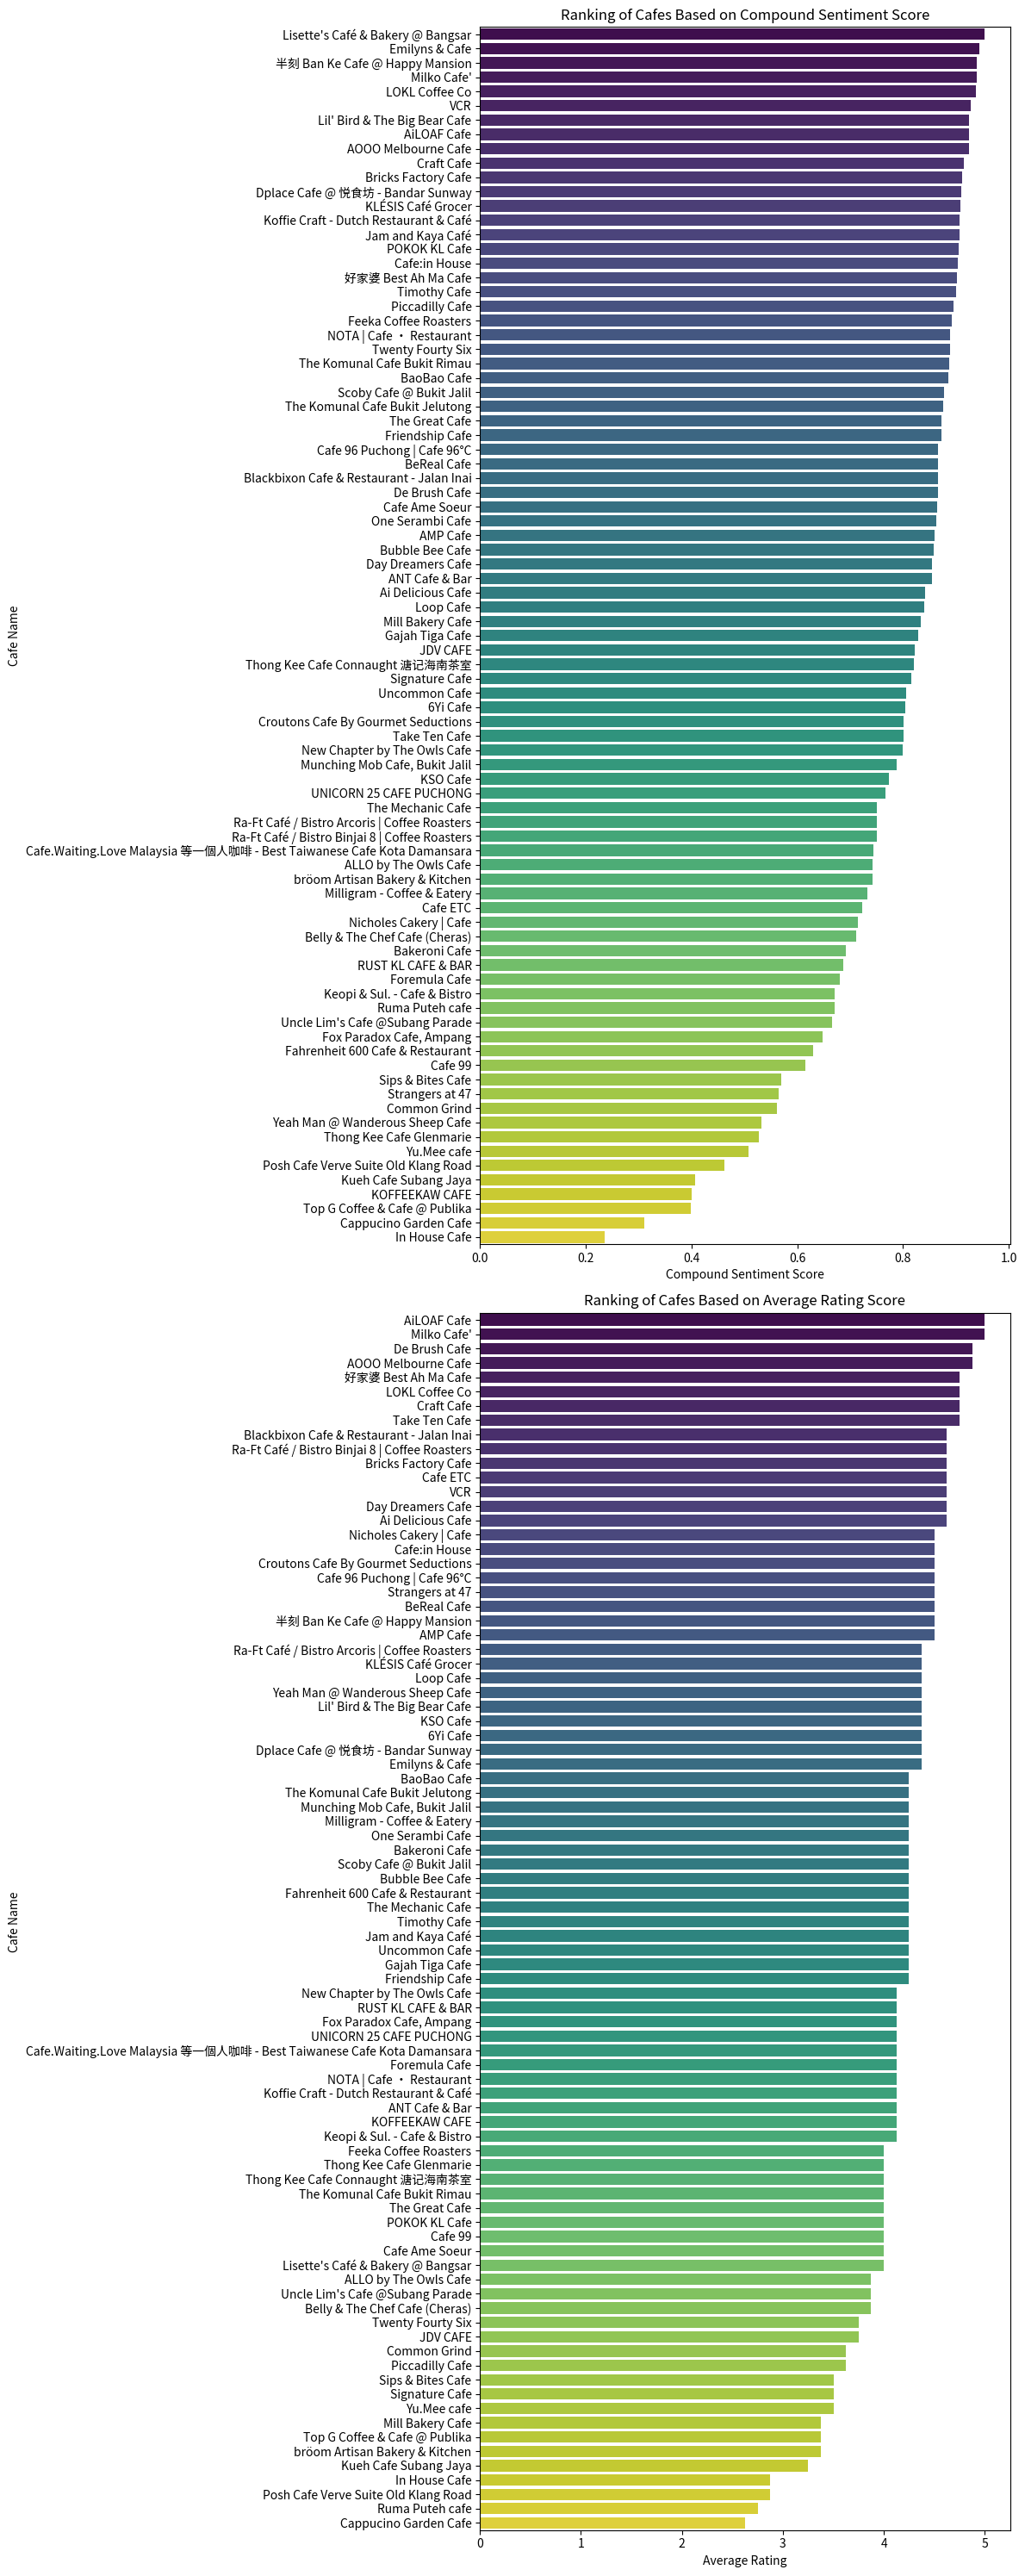

In [29]:
# Set the font family to one that supports a wide range of characters such as Chinese Characters
plt.rcParams['font.family'] = 'Noto Sans SC'
# Set the size of the plot
plt.figure(figsize=(12, 30))

# Create the first subplot
plt.subplot(2, 1, 1)
sns.barplot(x='compound_mean', y='cafe_name', hue="cafe_name", data=sort_by_compound, palette='viridis', dodge=False, legend=False)
plt.title('Ranking of Cafes Based on Compound Sentiment Score')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Cafe Name')

# Create the second subplot
plt.subplot(2, 1, 2)
sns.barplot(x='average_rating', y='cafe_name', hue="cafe_name", data=sort_by_rating, palette='viridis', dodge=False, legend=False)
plt.title('Ranking of Cafes Based on Average Rating Score')
plt.xlabel('Average Rating')
plt.ylabel('Cafe Name')

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plots
plt.show()

Section Conlcusion
* It seems that the rankings of most cafes have changed when ranked by average compound scores instead of average rating scores.
* Let us visualise this difference in rank by creating combining the "sort_by_compound" and "sort_by_rating" dataframes to calculate the change in rank.

### b. Merge the dataframes and calculate the "ranking_difference" (the between a cafe's rating ranking and its compound score ranking)

In [21]:
merged_df = pd.merge(sort_by_compound, sort_by_rating, on='cafe_name', how='inner')

# merged_df["compound_mean"] = merged_df["compound_mean_x"]
# merged_df["average_rating"] = merged_df["average_rating_x"]
# merged_df = merged_df.drop(columns=["compound_mean_x","compound_mean_y","average_rating_x","average_rating_y"], axis=1)

merged_df['ranking_difference'] = (merged_df['rating_ranking'] - merged_df['compound_ranking'])

sort_by_ranking_difference = merged_df.sort_values(by='ranking_difference', ascending=False).reset_index(drop=True)
sort_by_ranking_difference.head(5)

,cafe_name,compound_mean,compound_ranking,average_rating,rating_ranking,ranking_difference
0,Lisette's Café & Bakery @ Bangsar,0.954775,1,4.000,67,66
1,Piccadilly Cafe,0.895750,20,3.625,74,54
2,Twenty Fourty Six,0.888500,23,3.750,71,48
3,POKOK KL Cafe,0.905300,16,4.000,64,48
4,Koffie Craft - Dutch Restaurant & Café,0.907112,14,4.125,55,41


Section Conlcusion 1:
* Positive "ranking_difference" value shows how many ranks the cafe has improved from "rating_ranking" to "compound_ranking"
* Negative "ranking_difference" value shows how many ranks the cafe has worsened from "rating_ranking" to "compound_ranking"

In [22]:
# Calculate the number of rows where ranking_difference is >0, =0, and <0
greater_than_zero = sort_by_ranking_difference[sort_by_ranking_difference['ranking_difference'] > 0].shape[0]
equal_to_zero = sort_by_ranking_difference[sort_by_ranking_difference['ranking_difference'] == 0].shape[0]
less_than_zero = sort_by_ranking_difference[sort_by_ranking_difference['ranking_difference'] < 0].shape[0]

print(f"Number of cafes where ranking improved: {greater_than_zero}")
print(f"Number of cafes where ranking stayed the same: {equal_to_zero}")
print(f"Number of cafes where ranking worsened: {less_than_zero}")

Number of cafes where ranking improved: 38
Number of cafes where ranking stayed the same: 3
Number of cafes where ranking worsened: 44


In [24]:
# Calculate the number of rows where ranking_difference is >0, =0, and <0
greater_than_five = sort_by_ranking_difference[sort_by_ranking_difference['ranking_difference'] > 5].shape[0]
plus_minus_five = sort_by_ranking_difference[(sort_by_ranking_difference['ranking_difference'] <= 5) & (sort_by_ranking_difference['ranking_difference'] >= -5) ].shape[0]
less_than_negative_five = sort_by_ranking_difference[sort_by_ranking_difference['ranking_difference'] < -5].shape[0]

print(f"Number of cafes where ranking increased by more than 5 ranks: {greater_than_five}")
print(f"Number of cafes where ranking stayed within +- 5 ranks: {plus_minus_five}")
print(f"Number of cafes where ranking worsened by more than 5 ranks: {less_than_negative_five}")

Number of cafes where ranking increased by more than 5 ranks: 31
Number of cafes where ranking stayed within +- 5 ranks: 21
Number of cafes where ranking worsened by more than 5 ranks: 33


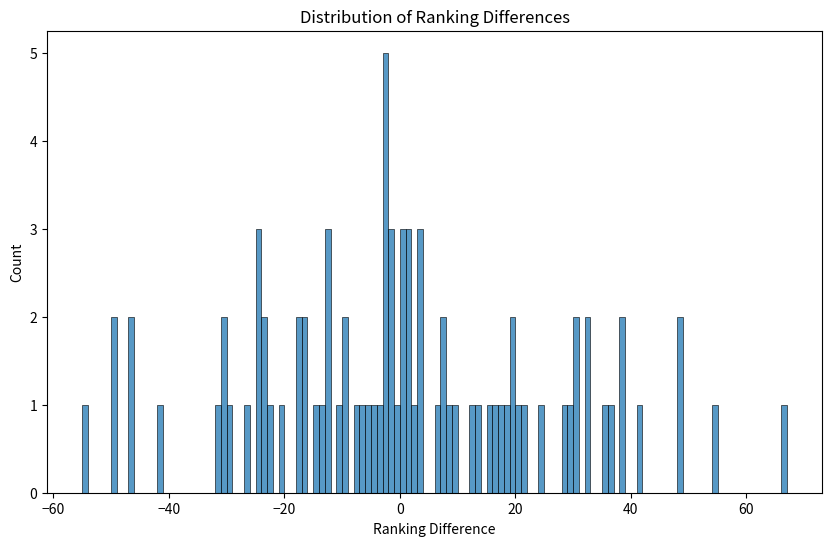

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(sort_by_ranking_difference['ranking_difference'], bins=range(min(sort_by_ranking_difference['ranking_difference']), max(sort_by_ranking_difference['ranking_difference']) + 2), kde=False)

# Add titles and labels
plt.title('Distribution of Ranking Differences')
plt.xlabel('Ranking Difference')
plt.ylabel('Count')

# Show the plot
plt.show()

Section Conlcusion 2:
* A large majority of reviews changed their rankings when sorted by compound score (instead of rating)
* Out of the cafes which rankings have changed, a slight majority of them had worse rankings when sorted by compound score (instead of rating)

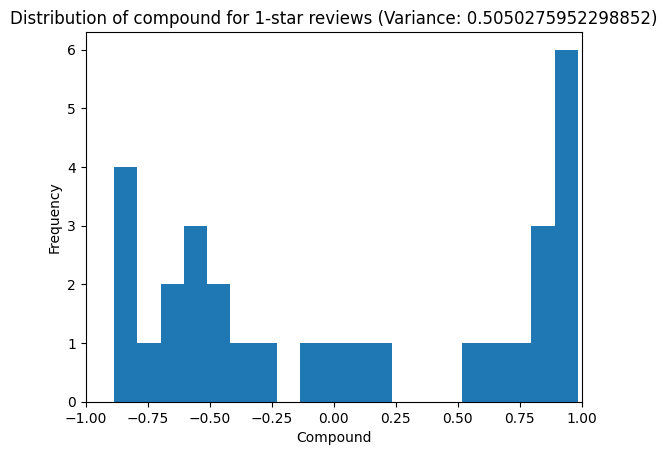

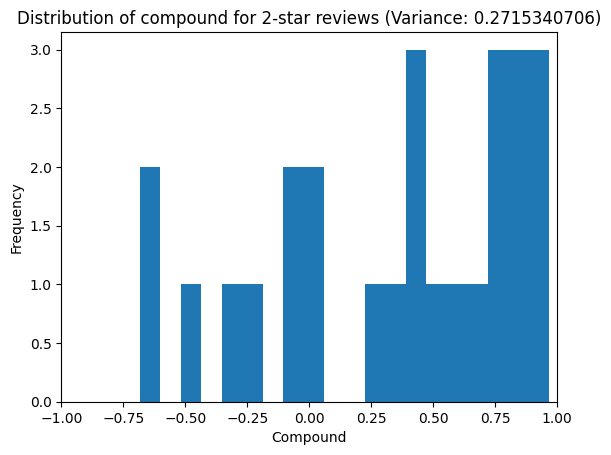

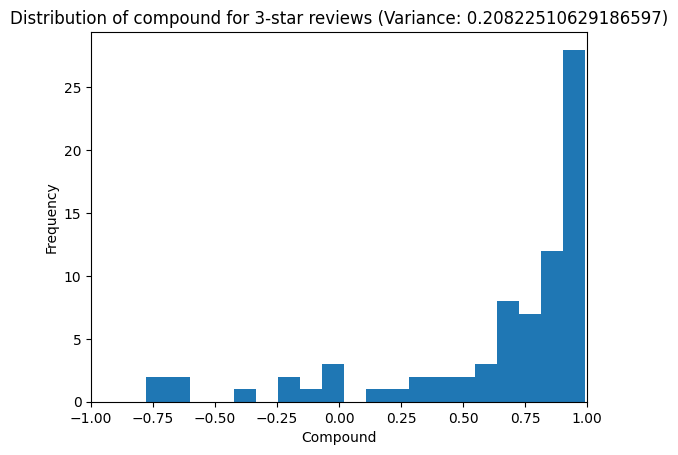

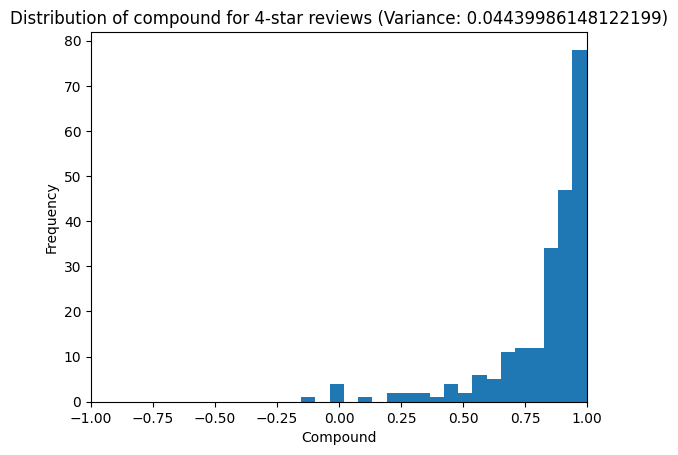

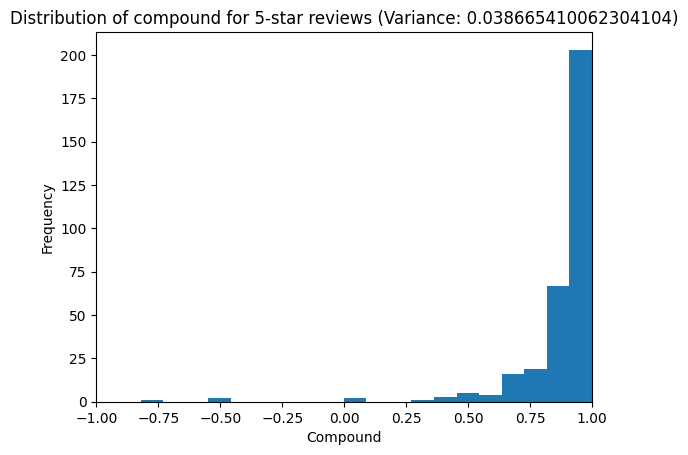

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named reviews_df with columns 'rating' and 'compound'

# Calculate variance of 'compound' for each rating
variance_by_rating = reviews_df.groupby('rating')['compound'].var()

# Visualize distribution of 'compound' for each rating
for rating, variance in variance_by_rating.items():
    plt.figure()
    reviews_df[reviews_df['rating'] == rating]['compound'].plot(kind='hist', bins=20, title=f'Distribution of compound for {rating}-star reviews (Variance: {variance})')
    plt.xlabel('Compound')
    plt.ylabel('Frequency')
    plt.xlim(-1, 1)  # Set x-axis limit to -1 to +1
    plt.show()

Section Conclusion 3:
* We can make a hypothesis that the rankings of cafes changed a lot because the dataset only contains 8 relevant reviews per cafe (small sample size) and a moderate variance of compound scores by rating (as shown in the visuals above)
* to prove this hypothesis, we will randomly split reviews into groups of X (where x is group size), then plotting the rank change histogram again.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_ranking_differences(df, group_size):
    # Assign a random group identifier to each row
    df['random_group'] = np.random.randint(0, (len(df) // group_size), size=len(df))

    # Group by the random_group column and aggregate the mean of compound and rating
    random_grouped_df = df.groupby('random_group').agg({
        'compound': 'mean',
        'rating': 'mean'
    }).reset_index()
    
    # Set column names
    random_grouped_df.columns = ['review_group', 'compound_mean', 'average_rating']
    
    # Sort by compound mean and assign compound rankings
    sort_by_compound_random = random_grouped_df.sort_values(by='compound_mean', ascending=False).reset_index(drop=True)
    sort_by_compound_random = sort_by_compound_random.drop('average_rating', axis=1)
    sort_by_compound_random["compound_ranking"] = range(1, len(sort_by_compound_random) + 1)
    
    # Sort by average rating and assign rating rankings
    sort_by_rating_random = random_grouped_df.sort_values(by='average_rating', ascending=False).reset_index(drop=True)
    sort_by_rating_random = sort_by_rating_random.drop('compound_mean', axis=1)
    sort_by_rating_random["rating_ranking"] = range(1, len(sort_by_rating_random) + 1)
    
    # Merge the DataFrames
    merged_df_random = pd.merge(sort_by_compound_random, sort_by_rating_random, on='review_group', how='inner')
    
    # Calculate ranking differences
    merged_df_random['ranking_difference'] = merged_df_random['rating_ranking'] - merged_df_random['compound_ranking']
    
    # Sort by ranking difference
    sort_by_ranking_difference_random = merged_df_random.sort_values(by='ranking_difference', ascending=False).reset_index(drop=True)
    
    # Plot histogram of ranking differences
    plt.figure(figsize=(10, 6))
    sns.histplot(sort_by_ranking_difference_random['ranking_difference'], bins=range(min(sort_by_ranking_difference_random['ranking_difference']), max(sort_by_ranking_difference_random['ranking_difference']) + 2), kde=False)

    # Add titles and labels
    plt.title(f'Distribution of Ranking Differences (Group Size = {group_size})')
    plt.xlabel('Ranking Difference')
    plt.ylabel('Count')

    # Show the plot
    plt.show()


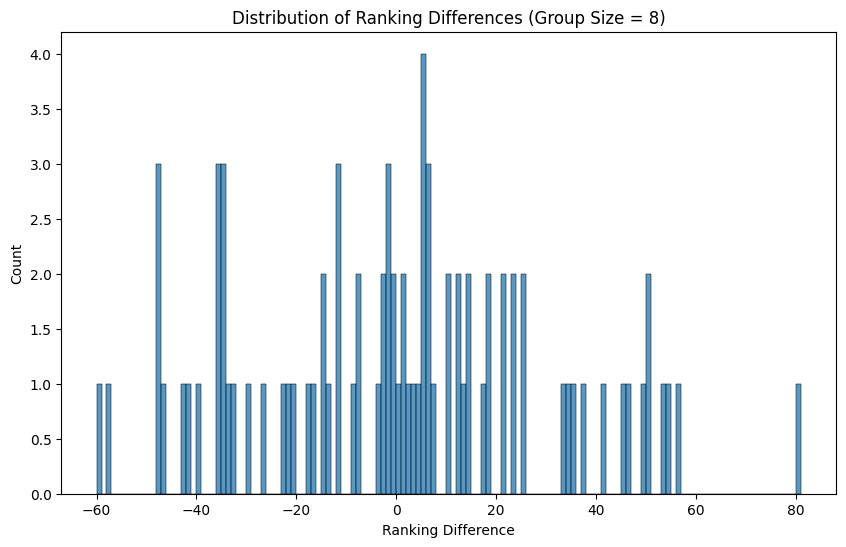

In [29]:
analyze_ranking_differences(reviews_df, 8)

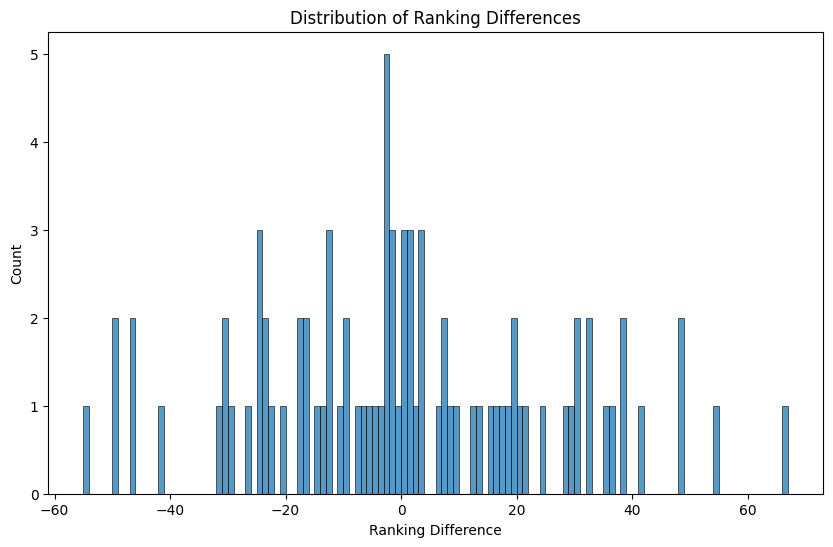

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(sort_by_ranking_difference['ranking_difference'], bins=range(min(sort_by_ranking_difference['ranking_difference']), max(sort_by_ranking_difference['ranking_difference']) + 2), kde=False)

# Add titles and labels
plt.title('Distribution of Ranking Differences')
plt.xlabel('Ranking Difference')
plt.ylabel('Count')

# Show the plot
plt.show()

Section Conclusion 4: The shape of the histogram when reviews are randomly grouped (with group size = 8) is familiar. It is similar to the ranking difference histogram when reviews are grouped by cafe.

#### Now let us try increasing the group size

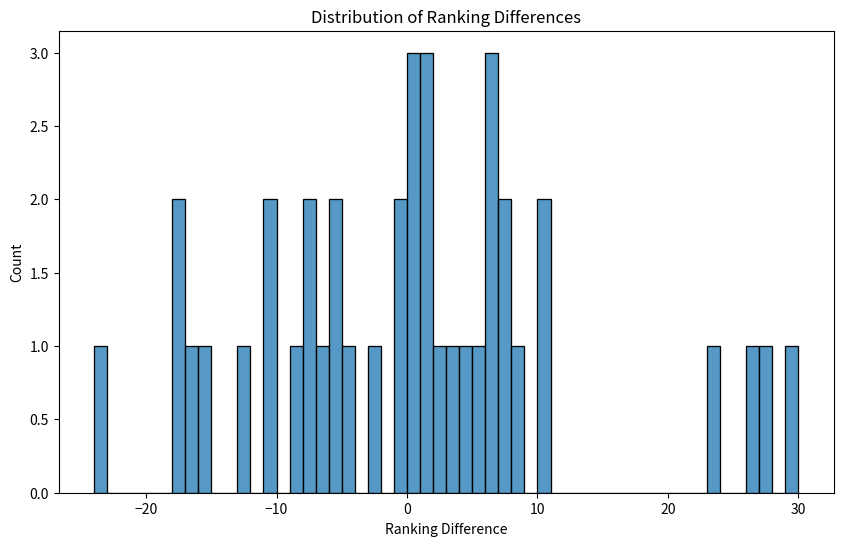

In [82]:
analyze_ranking_differences(reviews_df, 17)

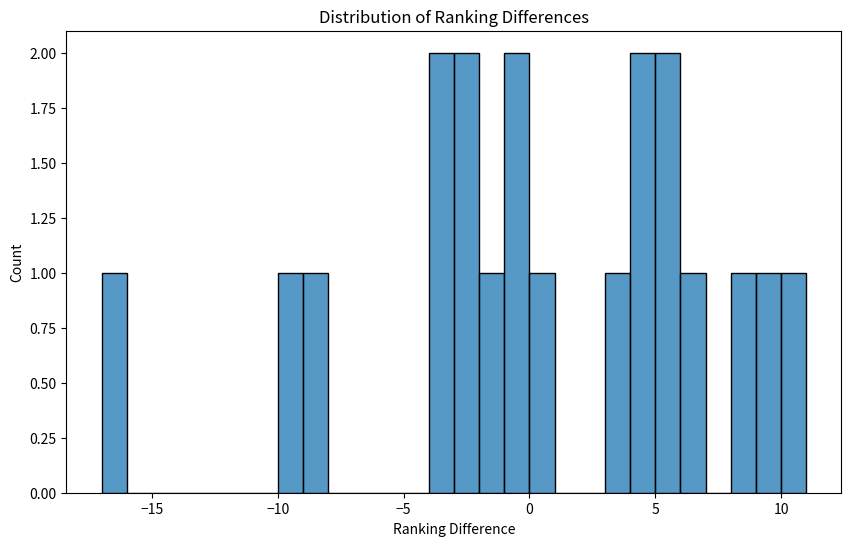

In [83]:
analyze_ranking_differences(reviews_df, 34)

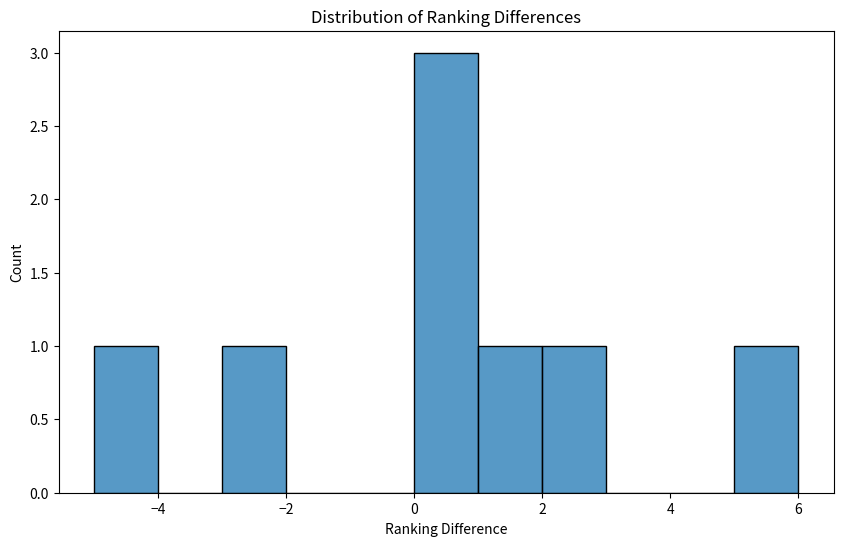

In [87]:
analyze_ranking_differences(reviews_df, 85)

Section Conclusion 5
* As you can see, as the group size of the reviews get larger, the ranking difference gets smaller.

# Overall Conclusion

* Sentiment score (Compound) increases with Rating
* Sentiment score (Compound) has a slight variance for each Rating
* This variance can affect accurate ranking of cafes if the sample size (number of reviews for each cafe) is too small
* Therefore, if a cafe review (perhaps in a blog, social media post or other text format) doesn't include a 1-5 rating score, we may get an accurate estimate of the cafe's ranking as long as we collect enough reviews for the cafe. Currently, around 85 reviews per cafe or more is enough to get a ranking difference (or error) of around 5 rankings.